# HumEnv Tutorial

This tutorial covers basic usage of HumEnv.

## All imports

It is important to set the relevant MuJoCo rendering environment variables before importing humenv. If rendering is not needed, you can skip setting the environment variables.

In [1]:
import os
os.environ["MUJOCO_GL"] = os.environ.get("MUJOCO_GL", "egl")
os.environ["PYOPENGL_PLATFORM"] = os.environ["MUJOCO_GL"]

from pathlib import Path
import mediapy as media
import sys
import inspect
import numpy as np
import json
from gymnasium.wrappers import FlattenObservation, TransformObservation

# humenv
import humenv
from humenv import make_humenv
from humenv.env import make_from_name
from humenv import rewards as humenv_rewards

# HumEnv basics

`make_humenv` is a custom environment creation function. It returns a tuple `(env, mp_info)`. This has a similar interface to the standard `gymnasium.make_vec` interface. 


`mp_info` is a dictionary containing information about [multiprocess manager](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Manager) and shared objects. For example, we use it to share the dataset of motions between different environments when using multiprocessing. In this case, `mp_info` will contain a manager `multiprocessing.Manager()` (`mp_info["manager"]`) and a shared motion buffer (`mp_info["motion_buffer"]`). Note that since `mp_info["motion_buffer"]` is a shared object, any change to this class will propagate to the processes. You should call `mp_info["manager"].shutdown()` before exiting the application.  

In [2]:
# make a single environment
env, mp_info = make_humenv()
print(f"environment: {env}")
print(f"mp_info: {mp_info}")

# As in gymnasium, `close` should be called when the environment is not needed anymore
env.close()
if mp_info is not None:
    mp_info["manager"].shutdown()

environment: <TimeLimit<OrderEnforcing<PassiveEnvChecker<HumEnv<humenv/HumEnv-v0.0.1>>>>>
mp_info: None


We can see that by default the environment is wrapped in a `TimeLimit` wrapper since we have a fix horizon of 300 steps. This can be easily changed by passing `max_episode_steps` to the make_humenv function

In [3]:
env, mp_info = make_humenv(max_episode_steps=1000)
print(f"time step: {env.spec.max_episode_steps}")
env.close()

time step: 1000


You can also create parallel environments and we use the standard `gymnasium` wrappers.

In [4]:
for mode in ["sync", "async"]:
    print(mode)
    env, mp_info = make_humenv(num_envs=4, vectorization_mode="async") # multiprocess
    print(f"environment: {env}")
    print(f"manager: {mp_info}")
    env.close()
    if mp_info is not None:
        mp_info["manager"].shutdown()
    print()

sync
environment: AsyncVectorEnv(num_envs=4)
manager: None

async
environment: AsyncVectorEnv(num_envs=4)
manager: None



**Environment creation options.** 

Let's take a look on the options available during HumEnv creation:
* `num_envs` - the number of requested environments
* `motions` - list of motion file names used to sample initiali positions if MoCap is used
* `motion_base_path` - where to look for motion files
* `wrappers` - a sequence of Gymansium wrappers to be applied for created env(s)
* `env_kwargs` - are passed to the HumEnv constructor, which in turns accepts:
* `task` -  reward function object or string that can instantiate such object.
* `xml` - the xml definition of the robot to be used, default to the tuned HumEnv robot
* `state_init` - the way random seed is generated
* `seed` - random seed
* `fall_prob` - the probability of fall initialization in a mixed initalization mode

    As well as rendering options passed to MuJoCo

# Observation and Rollouts

The observation in HumEnv is a dictionary containing the proprioceptive state.

In [5]:
env, _ = make_humenv()
print("Observation space")
for k,v in env.observation_space.items():
    print(f"{k}: {v}")
print(f"Action space: {env.action_space}")

Observation space
proprio: Box(-inf, inf, (358,), float64)
Action space: Box(-1.0, 1.0, (69,), float64)


Let's now interact with the environment

In [7]:
env.reset()
frames = [env.render()]
for i in range(60):
    env.step(env.action_space.sample())
    frames.append(env.render())
media.show_video(frames, fps=30)

*Why did we set `fps=30`?*

The control frequency of `HumEnv` is 30Hz. But the integration timestep is smaller.

In [8]:
print(f"dt={env.unwrapped.model.opt.timestep}")
print(f"action_repeat={env.unwrapped.action_repeat}")
print(f"control frequency: {env.unwrapped.model.opt.timestep * env.unwrapped.action_repeat}")

dt=0.0022222222222222222
action_repeat=15
control frequency: 0.03333333333333333


We can combine our environment with existing gymnasium wrappers. A useful transformer is the recently introduced [`NumpyToTorch`](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.NumpyToTorch).

In [9]:
env, _ = make_humenv(
    num_envs=1,
    wrappers=[
        FlattenObservation,
        lambda env: TransformObservation(env, lambda obs: obs.reshape(1, -1), None),
    ],
    seed=1,
)
obs, info = env.reset()
print(f"observation: {type(obs)}, {obs.shape}")
env.close()

observation: <class 'numpy.ndarray'>, (1, 358)


## Physics information and reset

The *physics* state of the Mujoco HumEnv simulator is given by
* Position: qpos
* Velocity: qvel

The state is entirely encapsulated in the `mjData` struct that can be accessed from `env.data`. We expose this information through the `info` dictionary in `reset` and `step`.

In [10]:
env, _ = make_humenv()
_, info = env.reset()
for k, v in info.items():
    print(f"{k}: {v.shape} -> {v[:11]}")
print((info["qpos"] == env.unwrapped.data.qpos).all())
print((info["qvel"] == env.unwrapped.data.qvel).all())

print('-'*10)
_, _, _, _, info = env.step(env.action_space.sample())
for k, v in info.items():
    print(f"{k}: {v.shape} -> {v[:11]}")

qpos: (76,) -> [0.         0.         0.94       0.70710678 0.70710678 0.
 0.         0.         0.         0.         0.        ]
qvel: (75,) -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True
True
----------
qpos: (76,) -> [-0.00981447  0.02123611  0.9301505   0.67624957  0.73495411 -0.01787618
 -0.04700445 -0.45475238  0.17156502  0.19298649  0.7948005 ]
qvel: (75,) -> [ -0.35790719   0.6409678   -0.50779128   0.81515442  -5.74455706
  -0.48867416 -11.82455898   4.20428937   7.66886461  24.78991097
   0.61636526]


These variables are important for resetting HumEnv in a particular situation and computing the reward. So it is important to keep track of these variables. We will see about the reward later on. Let's start with resetting the environment.

""

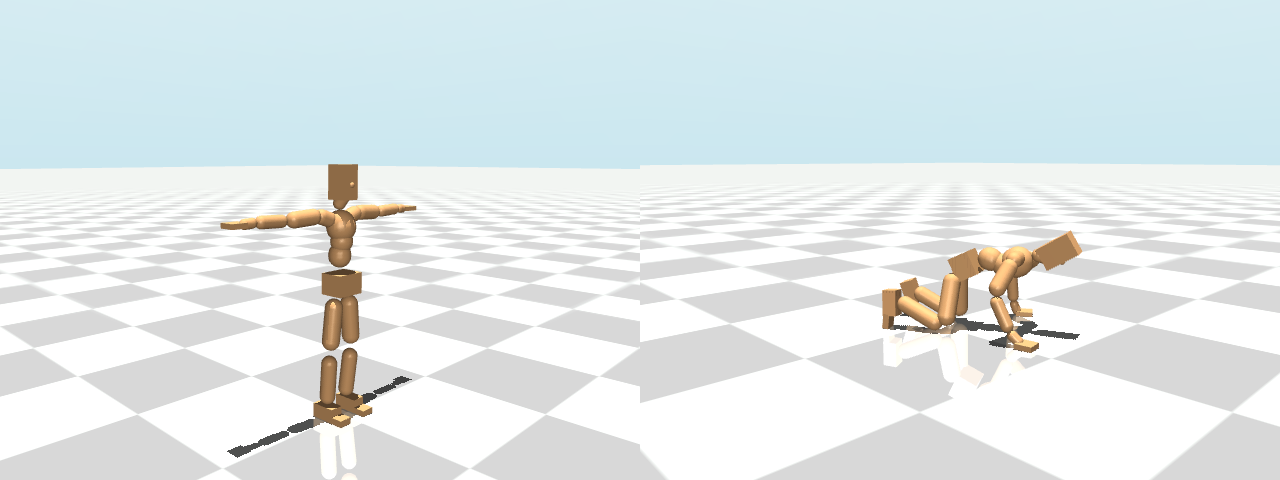

In [11]:
env.reset()
frame_0 = env.render()
new_qpos = np.array([0.13769039,-0.20029453,0.42305034,0.21707786,0.94573617,0.23868944
,0.03856998,-1.05566834,-0.12680767,0.11718296,1.89464102,-0.01371153
,-0.07981451,-0.70497424,-0.0478,-0.05700732,-0.05363342,-0.0657329
,0.08163511,-1.06263979,0.09788937,-0.22008936,1.85898192,0.08773695
,0.06200327,-0.3802791,0.07829525,0.06707749,0.14137152,0.08834448
,-0.07649805,0.78328658,0.12580912,-0.01076061,-0.35937259,-0.13176489
,0.07497022,-0.2331914,-0.11682692,0.04782308,-0.13571422,0.22827948
,-0.23456622,-0.12406075,-0.04466465,0.2311667,-0.12232673,-0.25614032
,-0.36237662,0.11197906,-0.08259534,-0.634934,-0.30822742,-0.93798716
,0.08848668,0.4083417,-0.30910404,0.40950143,0.30815359,0.03266103
,1.03959336,-0.19865537,0.25149713,0.3277561,0.16943092,0.69125975
,0.21721349,-0.30871948,0.88890484,-0.08884043,0.38474549,0.30884107
,-0.40933304,0.30889523,-0.29562966,-0.6271498])

env.unwrapped.set_physics(qpos=new_qpos, qvel=np.random.rand(75), ctrl=np.zeros(69)) # qvel and ctrl are optionals
# ctrl correspond to the action

# we can see that we moved the environment in a new state
media.show_image(np.concatenate([frame_0, env.render()], axis=1))

## Rewards

HumEnv comes with multiple parametric reward functions.

In [12]:
all_rewards = inspect.getmembers(sys.modules["humenv.rewards"], inspect.isclass)
for reward_class_name, reward_cls in all_rewards:
    if not inspect.isabstract(reward_cls):
        print(reward_class_name)

ArmsReward
CrawlReward
HeadstandReward
JumpReward
LieDownReward
LocomotionReward
MoveAndRaiseArmsReward
RotationReward
SitOnGroundReward
SplitReward
ZeroReward


This leads to a potentially infinite set of tasks. We provide a list of predefined reward function in `humenv.ALL_TASKS` which is a list of string. The reward class exposes a function to instantiate the tasks from their string-based name.

In [13]:
print(f"Number of predefined tasks: {len(humenv.ALL_TASKS)}")
print("Examples:")
print(humenv.LOCOMOTION_TASKS[:10])
print(humenv.ROTATION_TASKS[:10])
print("...")

Number of predefined tasks: 54
Examples:
['move-ego-0-2', 'move-ego-0-4', 'move-ego--90-2', 'move-ego--90-4', 'move-ego-90-2', 'move-ego-90-4', 'move-ego-180-2', 'move-ego-180-4']
['rotate-x--5-0.8', 'rotate-x-5-0.8', 'rotate-y--5-0.8', 'rotate-y-5-0.8', 'rotate-z--5-0.8', 'rotate-z-5-0.8']
...


You can instantiate a reward using their string-based representation or directly from using the class

In [14]:
reward_fn = make_from_name("jump-2")
print(reward_fn)
print(humenv_rewards.JumpReward(jump_height=1.6))

JumpReward(jump_height=2.0, max_velocity=5.0)
JumpReward(jump_height=1.6, max_velocity=5.0)


The reward class exposes a function `compute(model: mujoco.MjModel, data: mujoco.MjData)` that computes the rewards from the physics state of the simulator. Since `data` can be reconstructed using `qpos`, `qvel` and `ctrl`, we expose a call function `__call__(model: mujoco.MjModel, qpos: np.ndarray, qvel: np.ndarray, ctrl: np.ndarray)` This is why it is important to keep track of these variables if you plan to reset the environment or recompute the reward.
 **Note that `ctrl` correspond to the action.**

In [15]:
env, _ = make_humenv(task="move-ego-0-0")
env.reset()
action = env.action_space.sample()
_, reward, _, _, _ = env.step(action)
reward_fn = env.unwrapped.task
print(reward, ", reward from step")
print("Reward recomputation:")
print(reward_fn.compute(env.unwrapped.model, env.unwrapped.data), ", reward from model and data [Ok]")
print(reward_fn(env.unwrapped.model, env.unwrapped.data.qpos, env.unwrapped.data.qvel, np.zeros(69)), ", we passed the wrong action, the reward is not correct [No]")
print(reward_fn(env.unwrapped.model, env.unwrapped.data.qpos, env.unwrapped.data.qvel, action), ", we passed the correct action, the reward is correct [Ok]")

0.3943456330954772 , reward from step
Reward recomputation:
0.3943456330954772 , reward from model and data [Ok]
0.42684850526141904 , we passed the wrong action, the reward is not correct [No]
0.3943456330954772 , we passed the correct action, the reward is correct [Ok]


## Loading Motion Capture (MoCap) data

HumEnv supports motions from the AMASS dataset. The datasets needs to be separately downloaded and preprocessed with the [following instructions](data_preparation/README.md). We assume in the examples below that the prepared data exists in its default location:
```
data_preparation/humenv_amass
```

## Using MoCap to for the initial state setting

HumEnv supports the following initial states of the environment:

* Default - T-pose
* Fall - Random rotation of perturbed T-pose, may lead to unavoidable fall 
* MoCap - Random pose from the provided MoCap dataset
* DefaultAndFall - Random mixture of Default and Fall
* MoCapAndFall - Random mixture of MoCap and Fall

Below we present a MoCapAndFall initalization using the default location of the pre-processed data: 

  0%|          | 0/1 [00:00<?, ?it/s]

""

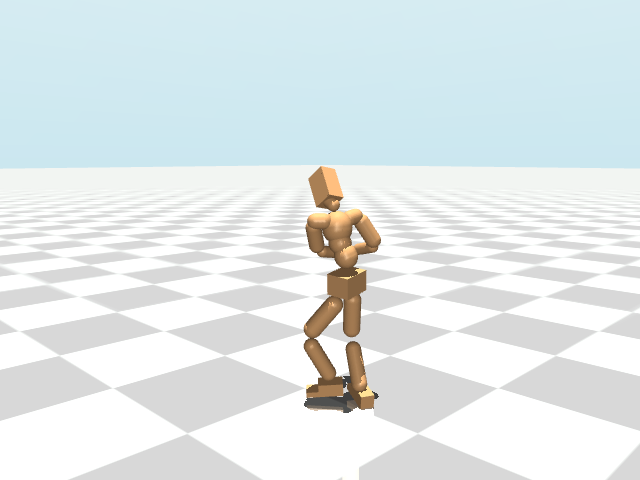

In [16]:
kwargs = {"state_init":"MoCap",}
motions_base_path = Path("data_preparation/humenv_amass")
if motions_base_path.exists():
    #Let's use only 10 motions for faster loading:
    motions = [str(x.name) for x in motions_base_path.glob("*.hdf5")][0:10]
    env, _ = make_humenv(motion_base_path=str(motions_base_path), motions=motions, **kwargs)  
    frame = env.render()
    media.show_image(frame)
else:
    print("[WARNING] You should generate the data before running these instructions")

## HumEnv Benchmark

HumEnv provides three benchmarking protocols:

* Reward (`humenv.bench.RewardEvaluation`) - evaluate on a set of reward tasks with pre-defined, paramterized objective functions
* Goal (`humenv.bench.GoalEvaluation`) - evaluate on a a set of poses 
* Tracking (`humenv.bench.TrackingEvaluation`) - evaluate on the set of motions from the MoCap dataset

The benchmark is optional and requires additional dependencies. It should be installed using `pip install humenv[bench]`.

Let's define first a RandomAgent that we will evaluate in the benchmark.

In [17]:
class RandomAgent:
    def __init__(self, env):
        self.env=env
    def act(self, obs, z):
        return self.env.action_space.sample()
    def reward_inference(self, task):
        return None
    def goal_inference(self, goal_pose):
        return None
    def tracking_inference(self, next_obs):
        return None

num_envs = 2
env , _= make_humenv(num_envs=num_envs)
random_agent = RandomAgent(env)

### Reward Evaluation

Reward evaluation allows to test an agent on a renge of reward tasks. It is highly customizable. In the following example:

- `tasks=['move-ego-0-0', 'jump-2']` means stand and jump
- `num_envs = 2` means we will create a vectorized environments with 2 environments
- `vectorization_mode='sync'` means we will use `gymnasium.vector.SyncVectorEnv`
- `num_episodes=4` means that in total, we will run 4 episodes of each task.
- `state_init=Fall` means that the episode starts from a random initial falling position.

The result of the evaluation is the `metrics` dictionary, which contains total reward and length for per episode for each task.

In [18]:
from humenv.bench import RewardEvaluation

reward_eval = RewardEvaluation(
        tasks=['move-ego-0-0', 'jump-2'],
        env_kwargs={ # this dictionary is passed to the environment constructor
            "state_init": "Fall", # random falling initialization
        }, 
        num_contexts=1, # the random agent is not a task conditioned agent so we use only one context
        num_envs=num_envs,
        num_episodes=4,
        vectorization_mode='sync'
    )
metrics = reward_eval.run(agent=random_agent)
print()
print("Results")
for k, v in metrics.items():
    print(f"task='{k}'")
    for k2, v2 in v.items():
        print(f"  {k2}: {v2}")
env.close()


Results
task='move-ego-0-0'
  reward: [np.float64(21.305938515210528), np.float64(19.28968067666476), np.float64(6.248346889093316), np.float64(20.327739830337308)]
  length: [300, 300, 300, 300]
task='jump-2'
  reward: [np.float64(0.7393722415457296), np.float64(0.7100111958672903), np.float64(0.7858174396259097), np.float64(0.6900716765565761)]
  length: [300, 300, 300, 300]


### Goal Evaluation

The overall structure is similar to reward benchmarking discussed above, so let's focus on differences. In goal evaluation, the agent should get as quickly as possible, and stay as close as possible to the goal pose.

The goal poses are prepared during AMASS data process, and are available by default in the file `data_preparation/goal_poses/goals.json`.  `GoalEvaluation` works as `RewardEvaluation`, but instead of list of tasks, it accepts dictionary of goal poses, formatted as `{"pose_name": observation_array}`.

Metrics for goal evaluation include reward (by default zero) and length, but also success (was the pose ever achieved with some tolerance), proximity (how muhc time humanoid spent within the tolerance threshold), and distance.

In [19]:
from humenv.bench import GoalEvaluation

pose_file = "data_preparation/goal_poses/goals.json"
with open(pose_file, "r") as json_file:
    goals = json.load(json_file)
for pose_name, payload in goals.items():
    goals[pose_name] = np.array(payload["observation"])

# shortlist for fast execution
shortlisted_goals = {k: goals[k] for k in ["t_pose", "handstand"]}

goal_eval = GoalEvaluation(
        goals=shortlisted_goals,
        env_kwargs={
            "state_init": "Default",
        },
        num_contexts=1,
        num_envs=num_envs,
        num_episodes=4,
        vectorization_mode='async'
    )
metrics = goal_eval.run(agent=random_agent)
print()
print("Results")
for k, v in metrics.items():
    print(f"task='{k}'")
    for k2, v2 in v.items():
        print(f"  {k2}: {v2}")
env.close()

Goal handstand: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Results
task='t_pose'
  reward: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
  length: [300, 300, 300, 300]
  success: [False, False, False, False]
  proximity: [0.002017148173516749, 0.001618827897727057, 3.361010680627737e-06, 0.0007317192580679089]
  distance: [10.509742305219426, 10.503319949277909, 10.438818936147335, 10.314733713301392]
task='handstand'
  reward: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
  length: [300, 300, 300, 300]
  success: [False, False, False, False]
  proximity: [0.0, 0.0, 0.0, 0.0]
  distance: [10.004728234721364, 10.036036273455858, 9.711179653706575, 9.862166294035754]


### Tracking Evaluation

The tracking benchmarking had more constrained protocol than the other ones: the humanoid is set to the first pose of a motion loaded from a MoCap file, and its objective is to stay as close to the next frame recorded in the MoCap trajectory. The length of the episodes is variable, and for a deterministic policy and deterministic simulator, such as MuJoCo, it does not make sense to repeat the episode for a given motion. 

In this example we take 5 first available motions, and evaluate them. `num_envs` regulates on how many workers the computation is spread.

The metrics set includes proximity, distance, success, emd (earth's mover distance), and a set of additional metric used in the literature.

In [20]:
from humenv.bench import TrackingEvaluation

num_envs = 1
# env is needed here only for RandomAgent
env, _ = make_humenv(num_envs=num_envs)
random_agent = RandomAgent(env)


motions_base_path = Path("data_preparation/humenv_amass")
if motions_base_path.exists():
    #Let's use only 5 motions for faster loading:
    motions = [str(x.name) for x in motions_base_path.glob("*.hdf5")][0:5]

    tracking_eval = TrackingEvaluation(
            motions=motions,
            num_envs=num_envs,
            motion_base_path=motions_base_path,
        )
    metrics = tracking_eval.run(agent=random_agent)
    print()
    print("Results")
    for k, v in metrics.items():
        print(f"task='{k}'")
        for k2, v2 in v.items():
            print(f"  {k2}: {v2}")
    env.close()
else:
    print("[WARNING] You should generate the data before running these instructions")


Results
task='0-Eyes_Japan_Dataset_hamada_gesture_etc-43-brushteeth-hamada_poses.hdf5'
  proximity: 0.001036947243846953
  distance: 10.990825653076172
  success: 0.0
  emd: 10.681026093093811
  mpjpe_g: 3818.7744140625
  vel_dist: 1192.0313720703125
  accel_dist: 1759.2967529296875
  success_phc_linf: 0.0
  success_phc_mean: 0.0
  motion_id: 7024
task='0-BMLmovi_Subject_1_F_MoSh_Subject_1_F_16_poses.hdf5'
  proximity: 0.01618983969092369
  distance: 9.501373291015625
  success: 0.0
  emd: 9.206989843566138
  mpjpe_g: 3243.37939453125
  vel_dist: 760.9938354492188
  accel_dist: 1042.0654296875
  success_phc_linf: 0.0
  success_phc_mean: 0.0
  motion_id: 1087
task='0-KIT_1226_Trial_79_poses.hdf5'
  proximity: 0.0019226979929953814
  distance: 11.049057006835938
  success: 0.0
  emd: 10.701017905323074
  mpjpe_g: 3768.3037109375
  vel_dist: 1148.047607421875
  accel_dist: 1677.2337646484375
  success_phc_linf: 0.0
  success_phc_mean: 0.0
  motion_id: 7822
task='0-BioMotionLab_NTroje_rub